In [1]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [2]:
doc = nlp("The quick brown fox jumped over the lazy dog. Alice hates spiders. Bob loves skeletons.")
max_w_len = max([len(token.text) for token in doc])
for token in doc:
    print(f"{token.text + ' '*(max_w_len-len(token.text))}  | {token.dep_}\t| {token.pos_}\t{token.tag_}\t{spacy.explain(token.tag_)}")

The        | det	| DET	DT	determiner
quick      | amod	| ADJ	JJ	adjective
brown      | amod	| ADJ	JJ	adjective
fox        | nsubj	| PROPN	NNP	noun, proper singular
jumped     | ROOT	| VERB	VBD	verb, past tense
over       | prep	| ADP	IN	conjunction, subordinating or preposition
the        | det	| DET	DT	determiner
lazy       | amod	| ADJ	JJ	adjective
dog        | pobj	| NOUN	NN	noun, singular or mass
.          | punct	| PUNCT	.	punctuation mark, sentence closer
Alice      | nsubj	| PROPN	NNP	noun, proper singular
hates      | ROOT	| VERB	VBZ	verb, 3rd person singular present
spiders    | dobj	| NOUN	NNS	noun, plural
.          | punct	| PUNCT	.	punctuation mark, sentence closer
Bob        | nsubj	| PROPN	NNP	noun, proper singular
loves      | ROOT	| VERB	VBZ	verb, 3rd person singular present
skeletons  | dobj	| NOUN	NNS	noun, plural
.          | punct	| PUNCT	.	punctuation mark, sentence closer


In [3]:
displacy.render(doc, style="dep")

# Split Sentences

In [4]:
sentences = [s for s in doc.sents]
sentence_parsings = [[token for token in s if token.pos != spacy.symbols.PUNCT] for s in sentences]
sentence_parsings

[[The, quick, brown, fox, jumped, over, the, lazy, dog],
 [Alice, hates, spiders],
 [Bob, loves, skeletons]]

# Assigning words to tokens

 - We use information from part-of-speech tags and the dependency structure. Note SpaCy uses [universal dependencies tags](https://universaldependencies.org/docs/u/pos/), so we aren't assigning basic types like e.g. the ones introduced in [Lambek2008](https://www.math.mcgill.ca/barr/lambek/pdffiles/2008lambek.pdf). See 'Ideas for further work' below.
 
 - `assign_words`
     1. Initially, the token is assigned its part-of-speech tag as codomain $C$.
     2. For each dependent token $t_l$ to the left, the codomain is replaced according to:
   
     $C \mapsto \textit{Ty}(t_l)^r \otimes C$,
     
     where $\textit{Ty}(t_l)^r$ is the right adjoint of $t_l$'s part-of-speech tag.
     3. Vice versa for the dependent tokens on the right:  $C \mapsto C\otimes \textit{Ty}(t_r)^l$.
     - _Addendum to step 1_: tokens with "ROOT" dependency is initially assigned the sentence type as codomain, to act as the "semantic output".

Input text: The quick brown fox jumped over the lazy dog. Alice hates spiders. Bob loves skeletons.

Basic types:{Ty('DET'), Ty('PROPN'), Ty('ADJ'), Ty('ADP'), Ty('NOUN'), Ty('s')}

Output diagrams:


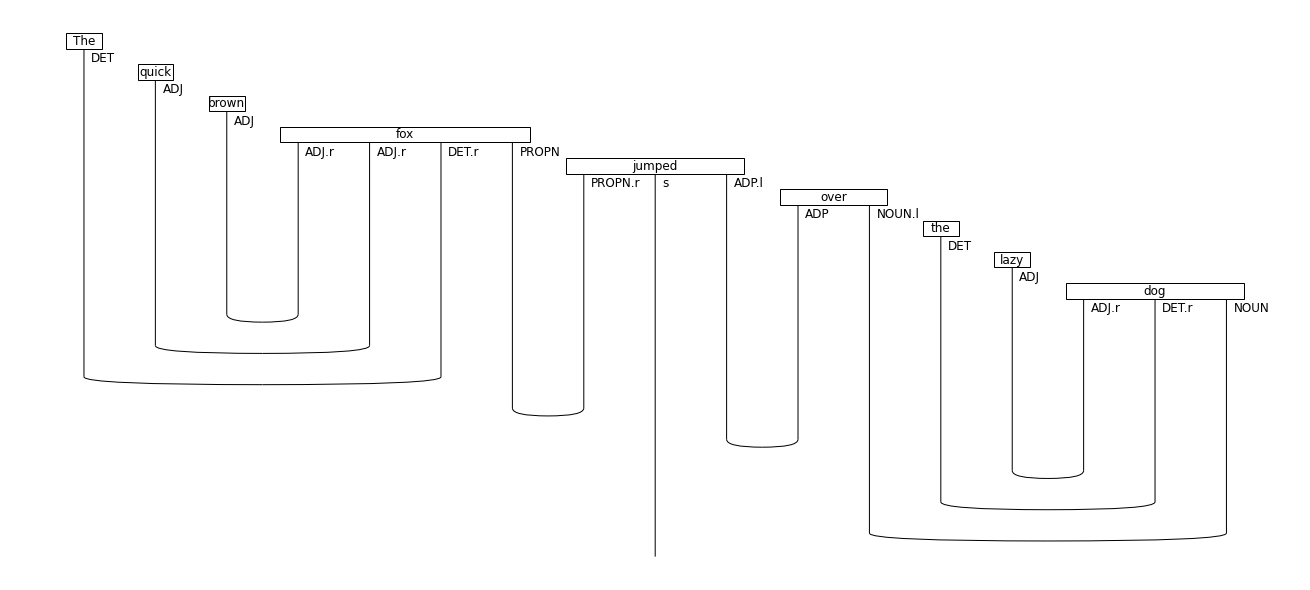

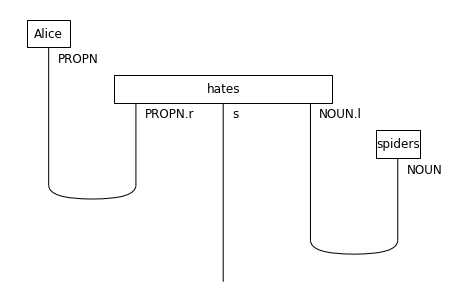

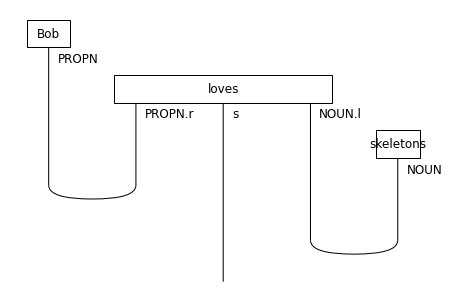

In [5]:
# import sys
# sys.path.append('../..')
import functools
from discopy import Ty, Word
from discopy.grammar import eager_parse

def assign_words(parsing, use_lemmas=False):
    """
    Given a parsing of some text (a list of spaCy tokens with punctuation removed), uses
    the part-of-speech tags and dependency structure to assign codomains to each word.
    
    The p-o-s tags constitute a set of basic types, and the codomains of the words are
    formed from tensor products of these basic types and their adjoints.
    
    In order to have a semantic output, a token with the 'ROOT' dependency tag is ensured
    to have a 'sentence' type in its codomain.
    
    Parameters
    ----------
    
    use_lemmas : bool
        use lemmas for names of the Word boxes e.g. 'loves' becomes Word('love', type)
        this is useful for simplifying a functor from sentence to circuit (we have less
        less words to specify the image of in the arrow mapping)
    """
    
    # a list of words and a set of basic types for this parsing
    words = []
    types = set()
    
    for token in parsing:
        
        # initial codomain
        ty = Ty('s') if token.dep_ == "ROOT" else Ty(token.pos_)
        # add to set of basic types (does nothing if type already in set)
        types.add(ty)

        # scan dependency tree and tensor codomain with appropriate left/right adjoints
        if token.n_lefts:
            lefts  = [Ty(token.pos_) for token in token.lefts if token in parsing]
            if len(lefts):
                ty = functools.reduce(lambda x,y: x @ y, lefts).r @ ty

        if token.n_rights:
            rights = [Ty(token.pos_) for token in token.rights if token in parsing]
            if len(rights): ty = ty @ functools.reduce(lambda x,y: x @ y, rights).l

        # add Word to list of Words in this parsing
        words.append(Word(token.lemma_ if use_lemmas else token.text, ty))
    
    return words, types


def sentence_to_diagram(parsing, **kwargs):
    """
    Takes a parsing of a sentence, assigns words to the tokens in the parsing, infers
    a set of basic types, and uses discopy's eager_parse to try and guess a diagram.
    """
    
    words, types = assign_words(parsing, **kwargs)
    
    try:
        diagram = eager_parse(*words)
    except:
        # this avoids an error if one of the sentences cannot be diagram-ed in
        # 'document_to_diagrams'
        print(f"Could not infer diagram from spaCy's tags: {parsing}")
        return None
    
    return diagram, types


def document_to_diagrams(doc, drop_stop=False, **kwargs):
    """
    Splits a document into sentences, and tries to create diagrams for each sentence,
    and a creates a set of all the basic types that were inferred from the document.

    Drops punctuation, and stop words if stop_words=True.
    """
    
    # split sentences and parse
    sentences = [s for s in doc.sents]
    sentence_parsings = [[token for token in s if (token.pos != spacy.symbols.PUNCT) and not (drop_stop and token.is_stop)] for s in sentences]
    
    # get diagrams for each sentence and a set of basic types for the whole document
    diagrams, types = map(list,zip(*[sentence_to_diagram(parsing, **kwargs) for parsing in sentence_parsings]))
    types = functools.reduce(lambda x,y: x.union(y), types)
    
    return diagrams, types


diagrams, types = document_to_diagrams(doc)
print(f"Input text: {doc}\n\nBasic types:{types}\n\nOutput diagrams:")
diagrams[0].draw(figsize=(18,8))
diagrams[1].draw()
diagrams[2].draw()

# Three sentences, three semantic outputs

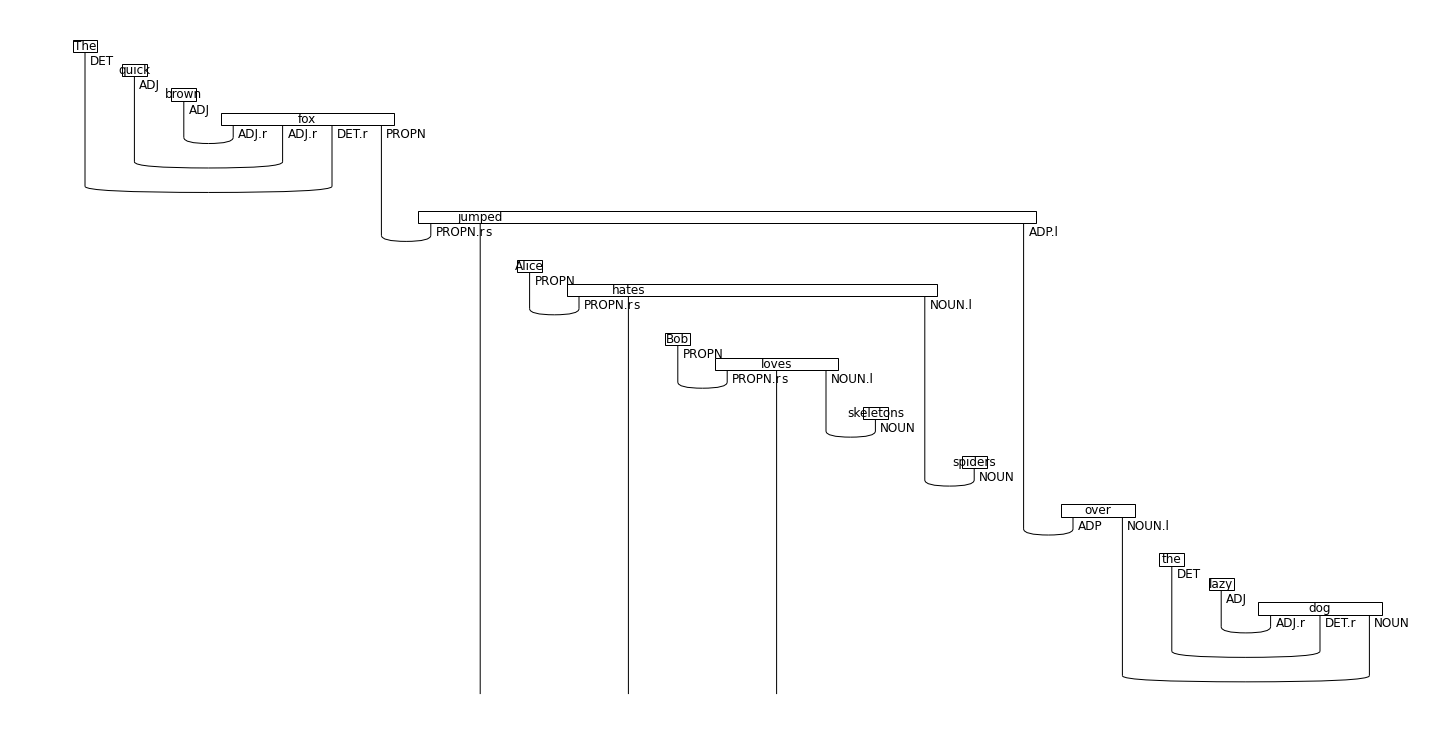

In [6]:
functools.reduce(lambda x,y: x@y, diagrams).normal_form().draw(figsize=(20,10))

# Ideas for further work:
- ### Functor to map part-of-speech tags used above ([universal dependencies](https://universaldependencies.org/docs/u/pos/)) to a pregroup that uses another set of basic types

- ### Morphological Features (person, number, verb tense, ...)
    - Could be used to introduce a partial order on the word types?

In [7]:
for token in doc: print(nlp.vocab.morphology.tag_map[token.tag_])

{74: 90}
{74: 84, 'Degree_pos': True}
{74: 84, 'Degree_pos': True}
{74: 96, 'NounType_prop': True, 'Number_sing': True}
{74: 100, 'Tense_past': True, 'VerbForm_fin': True}
{74: 85}
{74: 90}
{74: 84, 'Degree_pos': True}
{74: 92, 'Number_sing': True}
{74: 97, 'PunctType_peri': True}
{74: 96, 'NounType_prop': True, 'Number_sing': True}
{74: 100, 'Number_sing': True, 'Person_three': True, 'Tense_pres': True, 'VerbForm_fin': True}
{74: 92, 'Number_plur': True}
{74: 97, 'PunctType_peri': True}
{74: 96, 'NounType_prop': True, 'Number_sing': True}
{74: 100, 'Number_sing': True, 'Person_three': True, 'Tense_pres': True, 'VerbForm_fin': True}
{74: 92, 'Number_plur': True}
{74: 97, 'PunctType_peri': True}
